In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import imutils
import pandas as pd
import datetime
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
from sklearn import metrics
from sklearn.utils import shuffle
from skimage import draw
from skimage.io import imread,imsave
from skimage.filters import threshold_otsu
from sklearn.model_selection import train_test_split
from skimage.util import pad
import skimage
import time
import tqdm
import math
from DatasetCreator import create_data_vahadane
from tqdm import tqdm_notebook as tqdm 
from PatchExtractor import PatchExtractor
from Dataset import DataSet,Scale,ToTensor,RandomGaussionBlur,RandomMedianBlur\
,RandomHorizontalFlip,RandomRotation,visualize_loader

import warnings
warnings.filterwarnings('ignore')

from Models import DualEncoding_U_Net, save_model,load_model,init_weights
from Metrics import SoftDiceLoss,dice_metric,MultiClassBCE,SoftDiceLoss,DE_loss
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
if not os.path.exists('processed_data'):
    os.mkdir('processed_data')
    
import pickle

from PredictNucleiMask import whole_img_pred


The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


In [2]:

png_dir='norm_ideal'
annotation_dir='Annotations'
nucleus_dir='processed_data/nucleus_maps'
boundary_dir='processed_data/boundary_maps'
# create_data_vahadane(png_dir,annotation_dir,nucleus_dir,boundary_dir)


In [3]:
train_list=['TCGA-A7-A13E-01Z-00-DX1.png',\
'TCGA-A7-A13F-01Z-00-DX1.png',\
'TCGA-AR-A1AK-01Z-00-DX1.png',\
'TCGA-AR-A1AS-01Z-00-DX1.png',\
'TCGA-18-5592-01Z-00-DX1.png',\
'TCGA-38-6178-01Z-00-DX1.png',\
'TCGA-49-4488-01Z-00-DX1.png',\
'TCGA-50-5931-01Z-00-DX1.png',\
'TCGA-HE-7130-01Z-00-DX1.png',\
'TCGA-HE-7129-01Z-00-DX1.png',\
'TCGA-B0-5711-01Z-00-DX1.png',\
'TCGA-B0-5698-01Z-00-DX1.png',\
'TCGA-G9-6362-01Z-00-DX1.png',\
'TCGA-G9-6336-01Z-00-DX1.png',\
'TCGA-G9-6363-01Z-00-DX1.png',\
'TCGA-G9-6356-01Z-00-DX1.png']

test_list=list(set([x for x in os.listdir(png_dir) if x.split('.')[-1].lower()=='png'])-set(train_list))

# TRAIN

TCGA-A7-A13E-01Z-00-DX1.png<br/>
TCGA-A7-A13F-01Z-00-DX1.png<br/>
TCGA-AR-A1AK-01Z-00-DX1.png<br/>
TCGA-AR-A1AS-01Z-00-DX1.png<br/>
TCGA-18-5592-01Z-00-DX1.png<br/>
TCGA-38-6178-01Z-00-DX1.png<br/>
TCGA-49-4488-01Z-00-DX1.png<br/>
TCGA-50-5931-01Z-00-DX1.png<br/>
TCGA-HE-7130-01Z-00-DX1.png<br/>
TCGA-HE-7129-01Z-00-DX1.png<br/>
TCGA-B0-5711-01Z-00-DX1.png<br/>
TCGA-B0-5698-01Z-00-DX1.png<br/>
TCGA-G9-6362-01Z-00-DX1.png<br/>
TCGA-G9-6336-01Z-00-DX1.png<br/>
TCGA-G9-6363-01Z-00-DX1.png<br/>
TCGA-G9-6356-01Z-00-DX1.png


# TEST

TCGA-E2-A14V-01Z-00-DX1.png<br/>
TCGA-G2-A2EK-01A-02-TSB.png<br/>
TCGA-21-5786-01Z-00-DX1.png<br/>
TCGA-CH-5767-01Z-00-DX1.png<br/>
TCGA-AY-A8YK-01A-01-TS1.png<br/>
TCGA-G9-6348-01Z-00-DX1.png<br/>
TCGA-B0-5710-01Z-00-DX1.png<br/>
TCGA-KB-A93J-01A-01-TS1.png<br/>
TCGA-RD-A8N9-01A-01-TS1.png<br/>
TCGA-21-5784-01Z-00-DX1.png<br/>
TCGA-E2-A1B5-01Z-00-DX1.png<br/>
TCGA-DK-A2I6-01A-01-TS1.png<br/>
TCGA-NH-A8F7-01A-01-TS1.png<br/>
TCGA-HE-7128-01Z-00-DX1.png

In [4]:
h_e_train_dir='processed_data/h_e_train_dir'
h_train_dir='processed_data/h_train_dir'
nuclei_mask_train_dir='processed_data/nuclei_mask_train_dir'
boundary_mask_train_dir='processed_data/boundary_mask_train_dir'
if not os.path.exists(h_e_train_dir):
    os.mkdir(h_e_train_dir)
if not os.path.exists(h_train_dir):
    os.mkdir(h_train_dir)
if not os.path.exists(nuclei_mask_train_dir):
    os.mkdir(nuclei_mask_train_dir)
if not os.path.exists(boundary_mask_train_dir):
    os.mkdir(boundary_mask_train_dir)
# for img in tqdm(train_list):
#     nuclei=img.split('.')[0]+'_nucleus_mask.png'
#     boundary=img.split('.')[0]+'_boundary_mask.png'
#     os.system("cp {} {}".format(os.path.join('norm_ideal',img),os.path.join(h_e_train_dir,img)))
#     os.system("cp {} {}".format(os.path.join('H_gray',img),os.path.join(h_train_dir,img)))
#     os.system("cp {} {}".format(os.path.join('processed_data/nucleus_maps',nuclei),os.path.join(nuclei_mask_train_dir,nuclei)))
#     os.system("cp {} {}".format(os.path.join('processed_data/boundary_maps',boundary)\
#                                 ,os.path.join(boundary_mask_train_dir,boundary)))
    
    

In [5]:
h_e_test_dir='processed_data/h_e_test_dir'
h_test_dir='processed_data/h_test_dir'
nuclei_mask_test_dir='processed_data/nuclei_mask_test_dir'
boundary_mask_test_dir='processed_data/boundary_mask_test_dir'
if not os.path.exists(h_e_test_dir):
    os.mkdir(h_e_test_dir)
if not os.path.exists(h_test_dir):
    os.mkdir(h_test_dir)
if not os.path.exists(nuclei_mask_test_dir):
    os.mkdir(nuclei_mask_test_dir)
if not os.path.exists(boundary_mask_test_dir):
    os.mkdir(boundary_mask_test_dir)

# for img in tqdm(test_list):
#     nuclei=img.split('.')[0]+'_nucleus_mask.png'
#     boundary=img.split('.')[0]+'_boundary_mask.png'
#     os.system("cp {} {}".format(os.path.join('norm_ideal',img),os.path.join(h_e_test_dir,img)))
#     os.system("cp {} {}".format(os.path.join('H_gray',img),os.path.join(h_test_dir,img)))
#     os.system("cp {} {}".format(os.path.join('processed_data/nucleus_maps',nuclei),os.path.join(nuclei_mask_test_dir,nuclei)))
#     os.system("cp {} {}".format(os.path.join('processed_data/boundary_maps',boundary)\
#                                 ,os.path.join(boundary_mask_test_dir,boundary)))
    
    

In [6]:
h_e_train_patch_dir='processed_data/h_e_train_patch_dir'
h_train_patch_dir='processed_data/h_train_patch_dir'
nuclei_mask_train_patch_dir='processed_data/nuclei_mask_train_patch_dir'
boundary_mask_train_patch_dir='processed_data/boundary_mask_train_patch_dir'

# train_extractor=PatchExtractor(h_e_train_dir,h_train_dir,nuclei_mask_train_dir\
#                  ,boundary_mask_train_dir,h_e_train_patch_dir,h_train_patch_dir,\
#                  nuclei_mask_train_patch_dir,boundary_mask_train_patch_dir,gray=True,progress_bar=True)
# train_extractor.extract_patches(patch_size=128,step=64)

In [7]:
h_e_test_patch_dir='processed_data/h_e_test_patch_dir'
h_test_patch_dir='processed_data/h_test_patch_dir'
nuclei_mask_test_patch_dir='processed_data/nuclei_mask_test_patch_dir'
boundary_mask_test_patch_dir='processed_data/boundary_mask_test_patch_dir'

# test_extractor=PatchExtractor(h_e_test_dir,h_test_dir,nuclei_mask_test_dir\
#                  ,boundary_mask_test_dir,h_e_test_patch_dir,h_test_patch_dir,\
#                  nuclei_mask_test_patch_dir,boundary_mask_test_patch_dir,gray=True,progress_bar=True)
# test_extractor.extract_patches(patch_size=128,step=64)

900
788


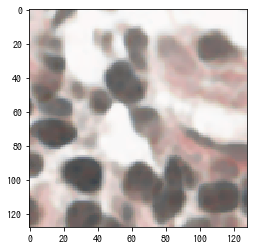

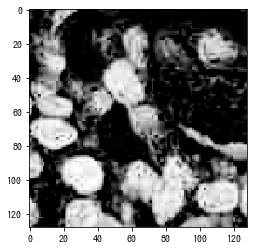

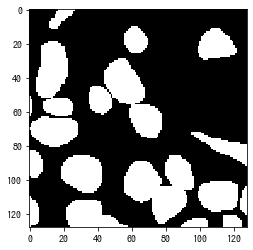

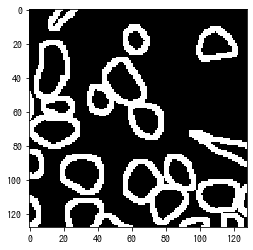

In [8]:
batch_size_train=4
batch_size_test=4
                                                
train_transform=torchvision.transforms.Compose([RandomMedianBlur(p=0.4),\
                                                RandomHorizontalFlip(p=0.4)\
                                               ,Scale(),ToTensor()])
test_transform=torchvision.transforms.Compose([Scale(),ToTensor()])
train_dataset=DataSet(h_e_train_patch_dir,h_train_patch_dir\
                      ,nuclei_mask_train_patch_dir, boundary_mask_train_patch_dir\
                      ,transform=train_transform,attn_gray=True)
train_loader=DataLoader(train_dataset,batch_size=batch_size_train,shuffle=True)
test_dataset=DataSet(h_e_test_patch_dir,h_test_patch_dir\
                      ,nuclei_mask_test_patch_dir, boundary_mask_test_patch_dir\
                      ,transform=test_transform,attn_gray=True)
test_loader=DataLoader(test_dataset,batch_size=batch_size_test,shuffle=True)

print(train_loader.__len__())
print(test_loader.__len__())
visualize_loader(test_loader,0)

In [9]:
model=DualEncoding_U_Net(img1_ch=3,img2_ch=1,output_ch=2,dropout=0.5)
# model=AttnUNet(img_ch=2,output_ch=1,dropout=0.5)
model_start_date=datetime.datetime.now().strftime("%Y_%m_%d")
BEST_MODEL_PATH=os.path.join(os.getcwd(),'model_{}'.format(model_start_date))
if not os.path.exists(BEST_MODEL_PATH):
    os.mkdir(BEST_MODEL_PATH)
    print('{} dir has been made'.format(BEST_MODEL_PATH))
print("Model's state_dict:")
writer = SummaryWriter('{}/experiment_{}'.format(BEST_MODEL_PATH,1))
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/datalab/training-assets/R_medical/atheeth/nuclei_seg/model_2020_01_23 dir has been made
Model's state_dict:
Conv1_encoding_1.conv.0.weight 	 torch.Size([64, 3, 3, 3])
Conv1_encoding_1.conv.0.bias 	 torch.Size([64])
Conv1_encoding_1.conv.1.weight 	 torch.Size([64])
Conv1_encoding_1.conv.1.bias 	 torch.Size([64])
Conv1_encoding_1.conv.1.running_mean 	 torch.Size([64])
Conv1_encoding_1.conv.1.running_var 	 torch.Size([64])
Conv1_encoding_1.conv.1.num_batches_tracked 	 torch.Size([])
Conv1_encoding_1.conv.3.weight 	 torch.Size([64, 64, 3, 3])
Conv1_encoding_1.conv.3.bias 	 torch.Size([64])
Conv1_encoding_1.conv.4.weight 	 torch.Size([64])
Conv1_encoding_1.conv.4.bias 	 torch.Size([64])
Conv1_encoding_1.conv.4.running_mean 	 torch.Size([64])
Conv1_encoding_1.conv.4.running_var 	 torch.Size([64])
Conv1_encoding_1.conv.4.num_batches_tracked 	 torch.Size([])
Conv2_encoding_1.conv.0.weight 	 torch.Size([128, 64, 3, 3])
Conv2_encoding_1.conv.0.bias 	 torch.Size([128])
Conv2_encoding_1.conv.1.we

In [ ]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
pretrained=False
optimizer_selected='adam'
scheduler_type='reduce_on_plateau'
batchsize=batch_size_train
no_steps=train_dataset.__len__()//batchsize
restart_epochs=8
num_epochs=50
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#criterion = SoftDiceLoss()#
# criterion=nn.BCELoss()
criterion=MultiClassBCE(weights=[0.65,0.35])
# criterion=DE_loss()

history={'train_loss':[],'test_loss':[],'train_dice':[],'test_dice':[]}
model = model.to(device)

if optimizer_selected=='adam':
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-03, betas=(0.9, 0.98),weight_decay=0.002)
else:
    optimizer = torch.optim.SGD(model.parameters(),lr=1e-03, momentum=0.8,nesterov=True)


if scheduler_type=='reduce_on_plateau':
    scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2,\
                                               verbose=True, threshold=0.0001, threshold_mode='rel',\
                                               cooldown=0, min_lr=10e-08, eps=1e-08)
    
else:
    scheduler=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, restart_epochs*no_steps,\
                                                     eta_min=1e-012, last_epoch=-1)

if pretrained:
    filename='model_2020_01_17/model_optim.pth'
    load_model(filename,model,optimizer=optimizer,scheduler=scheduler)
else:
    init_weights(model)

best_val=0
for epoch in range(num_epochs):
    
    print("Learning Rate : {}".format(optimizer.state_dict()['param_groups'][-1]['lr']))
    # loop over the dataset multiple times
    
    run_avg_train_loss=0
    run_avg_train_dice=0
    
   
    
    run_avg_test_loss=0
    run_avg_test_dice=0
    
    for mode in ['train','eval']:
     
        if mode == 'train':
            
            model.train()
            loop=tqdm(train_loader)
            
            for i, sample_batched in (enumerate(loop)):
                loop.set_description('Epoch {}/{}'.format(epoch + 1, num_epochs))
                
                #Clear Gradients
                optimizer.zero_grad()
                
                # get the inputs; data is a list of [dapi, nuclei, boundary]
                h_e_train, h_train,nuclei_mask_train,boundary_mask_train = sample_batched['h_e']\
                ,sample_batched['h']\
                ,sample_batched['nuclei_mask']\
                ,sample_batched['boundary_mask']
                
                h_e_train, h_train,nuclei_mask_train,boundary_mask_train = \
                h_e_train.to(device, dtype = torch.float),h_train.to(device, dtype = torch.float)\
                ,nuclei_mask_train.to(device, dtype = torch.float)\
                ,boundary_mask_train.to(device, dtype = torch.float)
                
                gt_mask_train=torch.cat((nuclei_mask_train,boundary_mask_train),dim=1)

                # forward + backward + optimize
#                 img_batch_comb=torch.cat((img_batch,dapi_batch),dim=1)
                outputs = torch.sigmoid(model(h_e_train,h_train))
                pred_nuclei_train,pred_boundary_train=torch.chunk(outputs,2,dim=1)
                

                
                loss = criterion(outputs, gt_mask_train)
                dice_score=dice_metric(pred_nuclei_train,nuclei_mask_train)
                run_avg_train_loss=(run_avg_train_loss*(0.9))+loss.detach().item()*0.1
                run_avg_train_dice=(run_avg_train_dice*(0.9))+dice_score.detach().item()*0.1
               
                if (i+1)%100==0:
                    

                    img_tensor=torch.cat((pred_nuclei_train.detach().cpu(),nuclei_mask_train.detach().cpu(),\
                                         pred_boundary_train.detach().cpu(),boundary_mask_train.detach().cpu()),dim=0)
                    
                    img_grid2 = torchvision.utils.make_grid(img_tensor,nrow=batch_size_train,padding=10)
                    torchvision.utils.save_image\
                    (img_grid2,os.path.join(BEST_MODEL_PATH,\
                                            'train_iter_{}.png'.format(epoch*len(train_loader)+i+1)))
                    
#                     writer.add_image('TRAIN_ITER_{}'.format(epoch * len(train_loader) + i+1), img_grid2)
                    
                    
                    writer.add_scalar('Training dice score nuclei',
                            run_avg_train_dice,
                            epoch * len(train_loader) + i+1)
                
                    writer.add_scalar('Training Loss',
                            run_avg_train_loss,
                            epoch * len(train_loader) + i+1)
                    
                loss.backward()
                optimizer.step()
                
                if scheduler_type!='reduce_on_plateau':
                    scheduler.step()
                
                
                loop.set_postfix(loss=run_avg_train_loss,dice_score=run_avg_train_dice)
                
               
            history['train_loss'].append(run_avg_train_loss)
            history['train_dice'].append(run_avg_train_dice)
            
            writer.add_scalar('Train dice { epoch }',
                            run_avg_train_dice,
                            epoch+1)
                
            writer.add_scalar('Train loss { epoch }',
                    run_avg_train_loss,
                    epoch * len(train_loader) + i+1)
                
                 
                    
        elif mode =='eval':
            #Clear Gradients
            optimizer.zero_grad()
            samples_test=len(test_loader)
            model.eval()
            val_loss=0
            test_agg=0
            for j, test_sample in enumerate(test_loader):

                h_e_test, h_test,nuclei_mask_test,boundary_mask_test = test_sample['h_e']\
                ,test_sample['h']\
                ,test_sample['nuclei_mask']\
                ,test_sample['boundary_mask']
                
                h_e_test, h_test,nuclei_mask_test,boundary_mask_test = \
                h_e_test.to(device, dtype = torch.float),h_test.to(device, dtype = torch.float)\
                ,nuclei_mask_test.to(device, dtype = torch.float)\
                ,boundary_mask_test.to(device, dtype = torch.float)
                
                
                gt_mask_test=torch.cat((nuclei_mask_test,boundary_mask_test),dim=1)
                test_outputs = torch.sigmoid(model(h_e_test,h_test))
                pred_nuclei_test,pred_boundary_test=torch.chunk(test_outputs,2,dim=1)
                
                test_loss = criterion(test_outputs, gt_mask_test)
                #final_test_loss+=test_loss.detach().item()
                test_dice=dice_metric(pred_nuclei_test,nuclei_mask_test)
                #final_test_dice+=test_dice
                run_avg_test_loss=(run_avg_test_loss*(0.9))+test_loss.detach().item()*0.1
                run_avg_test_dice=(run_avg_test_dice*(0.9))+test_dice.detach().item()*0.1
                
               
                if (j+1)%50==0:
                    
                    img_tensor_test=torch.cat((pred_nuclei_test.detach().cpu(),nuclei_mask_test.detach().cpu(),\
                                              pred_boundary_test.detach().cpu(),boundary_mask_test.detach().cpu()),dim=0)
                    
                    
                    img_grid = torchvision.utils.make_grid(img_tensor_test,nrow=batch_size_test,padding=10)
                    torchvision.utils.save_image\
                    (img_grid,os.path.join(BEST_MODEL_PATH,\
                                            'test_iter_{}.png'.format(epoch*len(test_loader)+j+1)))
                    
#                     writer.add_image('TEST_ITER_{}'.format(epoch * len(test_loader) + j+1), img_grid)
                    writer.add_scalar('Testing dice score ',\
                                      run_avg_test_dice,epoch * len(test_loader) + j+1)
                    
                    writer.add_scalar('Testing Loss',\
                                      run_avg_test_loss,epoch * len(test_loader) + j+1)
                
            print("test_loss: {}\ntest_dice :{}"\
                  .format(run_avg_test_loss,run_avg_test_dice))
            history['test_loss'].append(run_avg_test_loss)
            history['test_dice'].append(run_avg_test_dice)
            
            writer.add_scalar('Test dice { epoch }',
                            run_avg_test_dice,
                            epoch+1)
                
            writer.add_scalar('Test loss { epoch }',
                    run_avg_test_loss,
                    epoch * len(train_loader) + i+1)
            
            if run_avg_test_dice>best_val:
                best_val=run_avg_test_dice
                save_model(model,optimizer,BEST_MODEL_PATH+\
                           '/model_optim_dice.pth',scheduler=scheduler)
                print("saved model with test dice score: {}".format(best_val))
            if scheduler_type=='reduce_on_plateau':
                scheduler.step(run_avg_test_loss)
    
#             print("val_loss {}".format(val_loss/samples_test))
save_model(model,optimizer, BEST_MODEL_PATH+'/model_final.pth',scheduler=scheduler)    

with open("history.txt", "wb") as fp:   #Pickling
    pickle.dump(history, fp)

Tesla V100-SXM2-32GB
initialized network with normal initialization
Learning Rate : 0.001



test_loss: 0.272308357122437
test_dice :0.6031544096361663
saved model with test dice score: 0.6031544096361663
Learning Rate : 0.001


In [ ]:

# model=DualEncoding_U_Net(img1_ch=3,img2_ch=1,output_ch=2)
# filename='model_2020_01_16/model_optim.pth'
# pred_dir_name='predictionv2'
# # test_list=os.listdir('test_data/norm_ideal')
# load_model(filename,model,optimizer=None,scheduler=None)
# for img_name in ['TCGA-B0-5710-01Z-00-DX1.png']:
#     h_e_path=os.path.join('norm_ideal',img_name)
#     h_path=os.path.join('H_gray',img_name)
#     whole_img_pred(h_e_path,h_path,pred_dir_name,model,print_prompt=False)
    
# print("DONE")

In [ ]:
# !rm -rf model_2020_01_23

In [ ]:
# !rm -rf predictionv2/